In [1]:
import numpy as np
import matplotlib.pyplot as plt
from topoPy import *

In [2]:
lat = np.linspace(0, 2.0 * np.pi, 480)
lon = np.linspace(0, 2.0 * np.pi, 480)

vid = 0
clon_vertices = np.array([[0, np.pi, 2.0 * np.pi],])
clat_vertices = np.array([[0, 2.0 * np.pi, 0],])

lat_m, lon_m = np.meshgrid(lat,lon)
# z = np.sin(5.0*lon_m + 5.0*lat_m)
z = np.sin(1.0 * lon_m)

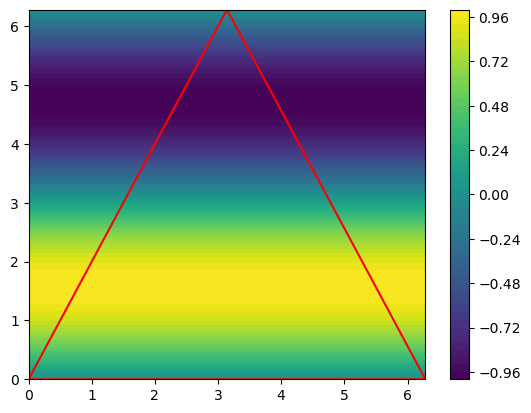

In [3]:
plt.contourf(lon,lat,z,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
plt.colorbar()
plt.show()

In [4]:
vi = clat_vertices[vid,:]
vj = clon_vertices[vid,:]
inout = [pointInTriangle(vi,vj,i,j) for i in lat for j in lon]
inout = np.array(inout).reshape(len(lat),len(lon))
# inout[...] = True
z_masked = z*inout

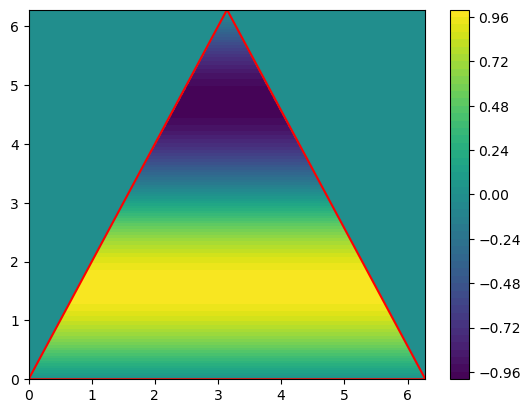

In [5]:
plt.contourf(lon,lat,z_masked,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
plt.colorbar()
plt.show()

In [6]:
def get_IJ(lat_rot, lon_rot, inout_rot, z_test):
    lat_cell,lon_cell,z_cell = lat_rot[inout_rot],lon_rot[inout_rot],z_test[inout_rot]

    # now define appropriate indices for the points withing the triangle
    # by shifting the origin to the minimum lat and lon
    lat_res = lat[1] - lat[0]
    lon_res = lon[1] - lon[0]
    
    # print(lat_res, lon_res)
    # lat_res = (lat[1] - lat[0]) * (2.0 * np.pi)
    # lon_res = (lon[1] - lon[0]) * (2.0 * np.pi)
    # lon_res = 2.0 * np.pi / 480.0
    # lat_res = 2.0 * np.pi / 480.0
    
    J = np.ceil((lat_cell - lat_cell.min())/lat_res).astype(int)
    I = np.ceil((lon_cell - lon_cell.min())/lon_res).astype(int)
    
    # J = ((lat_cell - lat_cell.min())/lat_res).astype(int)
    # I = ((lon_cell - lon_cell.min())/lon_res).astype(int)
    
    # p2 = 2.0 * np.pi / 50.0
    # p2 = 1.0 / 480.0
    
    # print(lat_cell)
    
    # J = np.around((lat_cell - lat_cell.min())/p2).astype(int)
    # I = np.around((lon_cell - lon_cell.min())/p2).astype(int)
     
    # J = np.ceil(lat_cell / p2).astype(int)
    # I = np.ceil(lon_cell / p2).astype(int)
    # J = lat_cell / p2
    # I = lon_cell / p2
    
    # print(lat_cell.shape)

    # print(I, J)
    # print(I.max(), J.max())
    
    return I, J, lat_cell, lon_cell, z_cell

In [7]:
def prepare_terms(lat_cell, lon_cell, I, J):
    
    Ni, Nj = np.unique(lat_cell).size, np.unique(lon_cell).size
    # Ni, Nj = lat_cell.size, lon_cell.size

    m_i = np.arange(0,nhar_i)
    if nhar_j == 2:
        m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)
    elif nhar_j % 2 == 0:
        m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)
    else:
        m_j = np.arange(-(nhar_j-1)/2,(nhar_j+1)/2)
        
    if debug_common:
        print("m_i; len(m_i); m_j; len(m_j)")
        print(m_i, len(m_i), '\n', m_j, len(m_j))

    term1 = m_i.reshape(1,-1) * I.reshape(-1,1) / Ni
    term2 = m_j.reshape(1,-1) * J.reshape(-1,1) / Nj
    
    return term1, term2, Ni, Nj, m_i, m_j

def axial_f_coeffs(lat_cell, lon_cell, I, J, k_range = 1, l_range = 1, alpha = 0.0):
    
    term1, term2, Ni, Nj, m_i, m_j = prepare_terms(lat_cell, lon_cell, I, J)
    
    alpha = alpha / 180.0 * np.pi
    
    ktil = m_i * np.cos(alpha)
    ltil = m_i * np.sin(alpha)
    
    term1 = ktil.reshape(1,-1) * I.reshape(-1,1) / Ni + ltil.reshape(1,-1) * J.reshape(-1,1) / Nj
    
    khat = m_j * np.cos(alpha + np.pi/2.0)
    lhat = m_j * np.sin(alpha + np.pi/2.0)
    
    term2 = khat.reshape(1,-1) * I.reshape(-1,1) / Ni + lhat.reshape(1,-1) * J.reshape(-1,1) / Nj
    
    bcos = 2.0 * np.cos(2.0 * np.pi * np.hstack([term1, term2[:,int(nhar_j/2):]]))
    bsin = 2.0 * np.sin(2.0 * np.pi * np.hstack([term1[:,1:], term2[:,int(nhar_j/2):]]))
    
    if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and (debug_axial)):
        print("term1: ")
        print(term1[999,...])
        print("term2: ")
        print(term2[999,...])
        
        print("bcos: ")
        print(bcos[999,...])

        print("bsin: ")
        print(bsin[999,...])

    Ncos = bcos[...]
    Nsin = bsin[...]
    
    return Ncos, Nsin

def full_f_coeffs(lat_cell, lon_cell, I, J):
    
    term1, term2, Ni, Nj, m_i, m_j = prepare_terms(lat_cell, lon_cell, I, J)
    
    
    term1 = np.expand_dims(term1,-1)
    term1 = np.repeat(term1,nhar_j,-1)
    term2 = np.expand_dims(term2,1)
    term2 = np.repeat(term2,nhar_i,1)
    
    term_sum = (term1[999:1001,...] + term2[999:1001,...])
    term_sum = term_sum.reshape(term_sum.shape[0], -1)

    tt_sum = term1 + term2
    tt_sum = tt_sum.reshape(tt_sum.shape[0],-1)

    bcos = 2.0 * np.cos(2.0 * np.pi * (tt_sum))
    bsin = 2.0 * np.sin(2.0 * np.pi * (tt_sum))

    if ((nhar_i == 2) and (nhar_j == 2)):
        Ncos = bcos[:,:]
        Nsin = bsin[:,1:]
        # Nsin = np.hstack((bsin[:,:2], bsin[:,3].reshape(-1,1)))#[:,1:]
    else:
        if (nhar_j % 2 == 0):
            Ncos = bcos[:,int(nhar_j/2-1):]
            Nsin = bsin[:,int(nhar_j/2):]
        else:
            Ncos = bcos[:,int(nhar_j/2-1):]
            Nsin = bsin[:,int(nhar_j/2):]

    if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and (debug_full)):
        print("term1: ")
        print(term1[999,...])
        print("term2: ")
        print(term2[999,...])
        print("term1; term2 shapes: ")
        print(term1.shape, term2.shape)

        print("term_sum: ")
        print(term_sum)
        print("term sum shape: ", term_sum.shape)

        print("bcos: ")
        print(bcos[999,...])

        print("bsin: ")
        print(bsin[999,...])
    
        print("Ncos: ")
        print(Ncos[999,...], Ncos.shape)
        
        print("Nsin: ")
        print(Nsin[999,...], Nsin.shape)
    
    return Ncos, Nsin

In [8]:
def get_recon(Ncos, Nsin, data, typ='full'):
    coeff = np.hstack([Ncos,Nsin])
    tot_coeff = coeff.shape[1]

    E_tilda_lm = np.zeros((tot_coeff,tot_coeff))
    # h_tilda_l = (data.reshape(-1,1) * coeff).sum(axis=0)
    h_tilda_l = np.dot(coeff.T, data.reshape(-1,1)).flatten()

    # for k in range(0,len(data)):
    #     E_tilda_lm += np.expand_dims(coeff[k],-1) * np.expand_dims(coeff[k],0)
    E_tilda_lm = np.dot(coeff.T, coeff)

    import scipy.linalg as la

    a_m = la.inv(E_tilda_lm).dot(h_tilda_l)

    # regular FFT considers normalization by total nu  mber of datapoints N=100
    # so multiply the Fourier coefficients by N here
    a_m = a_m#*len(data)
    
    fourier_coeff = np.zeros((nhar_i, nhar_j))
    nc = Ncos.shape[1]
    
    if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and ((debug_full) or (debug_axial)) and (debug_common)):
        print("coeff [999]: ")
        print(coeff[999,:])
        print("coeff shape: ")
        print(coeff.shape)
        print('Total coefficients:',tot_coeff)

        print("am shape = ", a_m.shape)
        print("am: ")
        print(a_m)

        print("nc (length of Ncos) = ", nc)
    
    zrs = np.zeros((int(nhar_j/2)-1))
    
    if typ == 'full':
        f00 = a_m[0]
        cos_terms = a_m[:nc]
        sin_terms = a_m[nc:]
        
        if ((nhar_i == 2) and (nhar_j == 2)):
            sin_terms = np.concatenate(([0.0],sin_terms))
        else:
            cos_terms = np.concatenate((zrs,cos_terms))
            sin_terms = np.concatenate((zrs,[0.0],sin_terms))
        
        fourier_coeff = (cos_terms + 1.0j * sin_terms) / 2.0
        fourier_coeff = fourier_coeff.reshape(nhar_i,nhar_j).swapaxes(1,0)

        if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and (debug_full)):
            print("cos terms, sin_terms: ")
            print(cos_terms, sin_terms)

            print("fourier_coeff: ")
            print(fourier_coeff)
        
    if typ == 'axial':
        f00 = a_m[0]
        cos_terms = a_m[:nc]
        sin_terms = a_m[nc:]
        sin_terms = np.concatenate(([0.0], sin_terms))
        
        if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and (debug_axial)):
            print("cos_terms")
            print(cos_terms)

            print("sin terms")
            print(sin_terms)
        if (nhar_j %2 == 0):
            k_terms = (cos_terms[:nhar_i] + 1.0j * sin_terms[:nhar_i]) / 2.0
            l_terms = (cos_terms[nhar_i:] + 1.0j * sin_terms[nhar_i:]) / 2.0
            
    
            if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and (debug_axial)):
                print("k-terms : ")
                print(k_terms, k_terms.shape)
                print("l-terms : ")
                print(l_terms, l_terms.shape)
            
            # y_axs = (cos_terms[:int(nhar_j/2-1)] + 1.0j * sin_terms[:int(nhar_j/2-1)]) / 2.0
            # x_axs = (cos_terms[int(nhar_j/2-1):] + 1.0j * sin_terms[int(nhar_j/2-1):]) / 2.0
            # x_axs = x_axs.reshape(-1,1)
            l_blk = np.zeros(( int(nhar_j/2-1), int(nhar_i) ))
            u_blk = np.zeros(( int(nhar_j/2), int(nhar_i-1) ))
            
            u_blk = np.hstack((l_terms.reshape(-1,1), u_blk))
            
            fourier_coeff = np.vstack((l_blk, k_terms, u_blk))
            
        else:
            y_axs = (cos_terms[:int((nhar_j+1)/2+1)] + 1.0j * sin_terms[:int((nhar_j+1)/2+1)]) / 2.0
            x_axs = (cos_terms[int((nhar_j-1)/2):] + 1.0j * sin_terms[int((nhar_j-1)/2):]) / 2.0
            x_axs = x_axs.reshape(-1,1)
            l_blk = np.zeros(( int(nhar_i-1), int((nhar_j-1)/2-1) ))
            u_blk = np.zeros(( int(nhar_i-1), int((nhar_j-1)/2) ))
            
            # print(x_axs.shape, l_blk.shape, u_blk.shape)
        
            r1 = np.hstack(([0]*int(nhar_j/2),[f00],y_axs)).reshape(1,-1)
            r2 = np.hstack((u_blk,x_axs,l_blk))
            fourier_coeff = np.vstack((r1,r2))
            fourier_coeff = fourier_coeff.T
            
    # print(f00)
        
    # fourier_coeff /= fourier_coeff.max()
    
    # reconstruct the dataset
    data_recons = coeff.dot(a_m)#/len(data)

    recons_z = data_recons
    
    return recons_z, fourier_coeff, coeff, a_m, nc

def recon_2D(recons_z, z, inout_rot):
    recons_z_2D = np.zeros(np.shape(z))
    c = 0
    for i in range(len(lat)):
        for j in range(len(lon)):
    #         if (inout[i,j] == 1):
    #             recons_z_2D[i,j] = recons_z[c]
    #             c = c+1

            if (inout_rot[i,j] == 1):
                recons_z_2D[i,j] = recons_z[c]
                c = c+1
                
    return recons_z_2D

In [9]:
plot_diag = False
debug_nh = 7
debug_full = False
debug_axial = False
debug_common = False

nhar_i = 12
nhar_j = 12

lon_rot, lat_rot = np.meshgrid(lon,lat)

Ncells_in_triangle = np.sum(inout)
I, J, lat_cell, lon_cell, z_cell = get_IJ(lat_rot, lon_rot, inout, z_masked)

Ncos, Nsin = full_f_coeffs(lat_cell, lon_cell, I, J)
recons_z, fourier_coeffs, CC, AM, NC = get_recon(Ncos, Nsin, z_cell)

fourier_coeffs_full = np.copy(fourier_coeffs)

slc = int(nhar_j / 2 - 1)
fcf = np.abs(fourier_coeffs_full).flatten('F')
fcf = fcf[slc:]

tarr = []

zrs = np.zeros((slc))
cos_terms = AM[:NC]
sin_terms = AM[NC:]
sin_terms = np.concatenate(([0.0],sin_terms))
xses = []
yses = []

inout_T = np.copy(inout)
inout_T[...] = True

I, J, lat_cell, lon_cell, z_cell = get_IJ(lon_m, lat_m, inout_T, z)

Ncos, Nsin = full_f_coeffs(lat_cell, lon_cell, I, J)
_, _, CCf, _, _ = get_recon(Ncos, Nsin, z_cell)

animate = False
if animate:
    for ii in range(fcf.size):

        c0 = cos_terms * 0.0
        s0 = sin_terms * 0.0

        idx_max = np.argmax(fcf)
        fcf[idx_max] = -np.inf
        tarr = np.append(tarr, int(idx_max))
        tarr = tarr.astype(int)

        idx_cos = tarr
        idx_sin = tarr + NC - 1

        curr_y = ((idx_cos[-1] + slc) % nhar_i) + 0.5
        curr_x = ((idx_cos[-1] + slc) // nhar_i) + 0.5

        ar = np.r_[idx_cos, idx_sin]

        c0[idx_cos] = cos_terms[idx_cos]
        s0[idx_cos] = sin_terms[idx_cos]

        c0 = np.concatenate((zrs,c0))
        s0 = np.concatenate((zrs,s0))

        fourier_coeff = (c0 + 1.0j * s0) / 2.0
        fourier_coeff = fourier_coeff.reshape(nhar_i,nhar_j).swapaxes(1,0)

        CCp = CC[:,ar]
        AMp = AM[ar]

        recons_z = CCp.dot(AMp)
        recons_z_2D = recon_2D(recons_z, z_masked, inout)

        ############################################

        CCp = CCf[:,ar]
        # AMp = AM[(idx_cos,idx_sin),]

        recons_z = CCp.dot(AMp)
        recons_z_2D_full = recon_2D(recons_z, z, inout_T)

        # fs = (4,3.8)
        # plt.figure(figsize=fs)
        # plt.imshow(recons_z_2D, vmin=-1.0, vmax=1.0, extent=extent, origin='lower')
        # plt.colorbar()
        # plt.show()
    #     im = plt.pcolormesh(np.abs(fourier_coeff), edgecolors='k', cmap='Greys')
    #     plt.colorbar(im,fraction=0.05, pad=0.04)

    #     if nhar_j % 2 == 0:
    #         m_j = np.arange(-nhar_j/2,nhar_j/2)
    #     else:
    #         m_j = np.arange(-(nhar_j-1)/2,(nhar_j)/2)

    #     ylocs = np.arange(.5,12.5,1.0)
    #     plt.yticks(ylocs, m_j)
    #     plt.xticks(ylocs, np.arange(0,12))
    #     plt.title("Power spectrum")
    #     plt.xlabel(r'$k_n$', fontsize=12)
    #     plt.ylabel(r'$l_m$', fontsize=12)
    #     plt.show()


    ###############################################

    #     fs = (10,3.8)
    #     fig, axs = plt.subplots(1, 2, figsize=fs)

    #     extent = [-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ]

    #     im2 = axs[0].imshow(recons_z_2D, vmin=-1.0, vmax=1.0, extent=extent, origin='lower')
    #     axs[0].set_title('Residual = %.3f' %np.linalg.norm(recons_z_2D - z_masked))
    #     fig.colorbar(im2, ax=axs[0])

    #     im3 = axs[1].pcolormesh(np.abs(fourier_coeff), edgecolors='k', cmap='Greys')
    #     axs[1].plot(curr_x,curr_y,'rx', ms=4) 
    #     axs[1].plot(xses,yses,'go', ms=4) 
    #     xses.append(curr_x)
    #     yses.append(curr_y)
    #     fig.colorbar(im3,ax=axs[1],fraction=0.05, pad=0.04)

    #     m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)

    #     ylocs = np.arange(.5,nhar_j+.5,1.0)

    #     axs[1].set_yticks(ylocs, m_j)
    #     axs[1].set_xticks(ylocs, np.arange(0,nhar_j))
    #     axs[1].set_title("Power spectrum")
    #     axs[1].set_xlabel(r'$k_n$', fontsize=12)
    #     axs[1].set_ylabel(r'$l_m$', fontsize=12)

    #     # plt.show()
    #     plt.savefig('img/frm_%.4d.png' %ii, bbox_inches='tight')
    #     plt.close()

    ###################################################

        fs = (15,3.8)
        fig, axs = plt.subplots(1, 3, figsize=fs)

        extent = [-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ]

        im2 = axs[0].imshow(recons_z_2D, vmin=-1.0, vmax=1.0, extent=extent, origin='lower')
        axs[0].set_title('Residual = %.3f' %np.linalg.norm(recons_z_2D - z_masked))
        fig.colorbar(im2, ax=axs[0])

        im4 = axs[1].imshow(recons_z_2D_full, vmin=-1.0, vmax=1.0, extent=extent, origin='lower')
        axs[1].set_title('Residual = %.3f' %np.linalg.norm(recons_z_2D_full - z_masked))
        fig.colorbar(im4, ax=axs[1])

        sidx = 2
        im3 = axs[sidx].pcolormesh(np.abs(fourier_coeff), edgecolors='k', cmap='Greys')
        axs[sidx].plot(curr_x,curr_y,'rx', ms=4) 
        axs[sidx].plot(xses,yses,'go', ms=4) 
        xses.append(curr_x)
        yses.append(curr_y)
        fig.colorbar(im3,ax=axs[sidx],fraction=0.05, pad=0.04)

        m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)

        ylocs = np.arange(.5,nhar_j+.5,1.0)

        axs[sidx].set_yticks(ylocs, m_j)
        axs[sidx].set_xticks(ylocs, np.arange(0,nhar_j))
        axs[sidx].set_title("Power spectrum")
        axs[sidx].set_xlabel(r'$k_n$', fontsize=12)
        axs[sidx].set_ylabel(r'$l_m$', fontsize=12)

        # plt.show()
        plt.savefig('img/frm_%.4d.png' %ii, bbox_inches='tight')
        plt.close()

# print(tarr)
# tarr = tarr.astype(int)
# idx_sort = np.argsort(fcf)

# print(slc)

# print(idx_sort)
# print(idx_max)

# print(idx_cos)
# print(idx_sin)
# print(idx_sin.min())

# inout_T = np.copy(inout)
# inout_T[...] = True

# I, J, lat_cell, lon_cell, z_cell = get_IJ(lon_m, lat_m, inout_T, z)

# Ncos, Nsin = full_f_coeffs(lat_cell, lon_cell, I, J)
# _, _, CC, _, _ = get_recon(Ncos, Nsin, z_cell)

# CCp = CC[:,(idx_cos,idx_sin)]
# AMp = AM[(idx_cos,idx_sin),]

# ar = np.r_[0:NC-10, NC:AM.size-10]
ar = np.r_[:101]

# print(ar)

# CCp = CC[:,(idx_cos,idx_sin)]
# AMp = AM[(idx_cos,idx_sin),]

# CCp = CC[:,:]
# AMp = AM[:]

# CCp = CC[:,ar]
# AMp = AM[ar]

# print(NC)
# print(CCp.shape)
# print(AMp.shape)

# recons_z = CCp.dot(AMp)
# print(recons_z.shape)

# recons_z_2D = recon_2D(recons_z, z, inout_T)
recons_z_2D = recon_2D(recons_z, z_masked, inout)

# print("\n==================== AXIAL ====================\n")

I, J, lat_cell, lon_cell, z_cell = get_IJ(lat_rot, lon_rot, inout, z_masked)

Ncos, Nsin = axial_f_coeffs(lat_cell, lon_cell, I, J, alpha=0.0)
recons_z, fourier_coeffs, _, _, _ = get_recon(Ncos, Nsin, z_cell, typ='axial')

recons_z_2D_axial = recon_2D(recons_z, z_masked, inout)

In [10]:
A = np.arange(0,25).reshape(5,5)
print(A)
print(A[:,(2,4)])

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[[ 2  4]
 [ 7  9]
 [12 14]
 [17 19]
 [22 24]]


In [38]:
fs = (12,16)
fig, axs = plt.subplots(3, 2, figsize=fs)
vmin = -1
vmax = 1

extent = [-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ]

im1 = axs[0,0].imshow(z_masked, vmin=vmin, vmax=vmax, extent=extent, origin='lower')
axs[0,0].set_title('original')
fig.colorbar(im1, ax=axs[0,0])

im6 = axs[0,1].imshow(np.abs(recons_z_2D - recons_z_2D_axial), extent=extent, origin='lower')
axs[0,1].set_title('abs. diff')
fig.colorbar(im6, ax=axs[0,1])

im2 = axs[1,0].imshow(recons_z_2D, extent=extent, origin='lower')
axs[1,0].set_title('full')
fig.colorbar(im2, ax=axs[1,0])

im3 = axs[1,1].pcolormesh(np.abs(fourier_coeffs_full), edgecolors='k', cmap='Greys')
fig.colorbar(im3,ax=axs[1,1],fraction=0.05, pad=0.04)

m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)
    
ylocs = np.arange(.5,nhar_j+.5,1.0)
# ylocs = np.arange(0,12)
# print(ylocs)
axs[1,1].set_yticks(ylocs, m_j)
axs[1,1].set_xticks(ylocs, np.arange(0,nhar_j))
axs[1,1].set_title("Power spectrum")
axs[1,1].set_xlabel(r'$k_n$', fontsize=12)
axs[1,1].set_ylabel(r'$l_m$', fontsize=12)

im4 = axs[2,0].imshow(recons_z_2D_axial, vmin=vmin, vmax=vmax, extent=extent, origin='lower')
axs[2,0].set_title('axial')
fig.colorbar(im4, ax=axs[2,0])

im5 = axs[2,1].pcolormesh(np.abs(fourier_coeffs), edgecolors='k', cmap='Greys')
fig.colorbar(im5,ax=axs[2,1],fraction=0.05, pad=0.04)
    
ylocs = np.arange(.5,nhar_j+0.5,1.0)
axs[2,1].set_yticks(ylocs, m_j)
axs[2,1].set_xticks(ylocs, np.arange(0,nhar_j))
axs[2,1].set_title("Power spectrum")
axs[2,1].set_xlabel(r'$k_n$', fontsize=12)
axs[2,1].set_ylabel(r'$l_m$', fontsize=12)

plt.show()
# print("Fourier ampls:")
# print((fourier_coeffs_full))
# print((fourier_coeffs))

# print("")
# print("abs(Fourier ampls):")
# print(np.abs(fourier_coeffs_full))
# print(np.abs(fourier_coeffs))

print("")
print((fourier_coeffs_full.max()), (fourier_coeffs.max()))
print(np.abs(fourier_coeffs_full.max()), np.abs(fourier_coeffs.max()))
print(np.abs(fourier_coeffs_full).max(), np.abs(fourier_coeffs).max())
# print(np.abs(fourier_coeffs_full).max() - np.abs(fourier_coeffs).max())
print(np.abs(fourier_coeffs_full).sum(), np.abs(fourier_coeffs).sum())
print(np.abs(fourier_coeffs_full).sum() / np.abs(fourier_coeffs).sum())
print(np.abs(fourier_coeffs_full).sum() - np.abs(fourier_coeffs).sum())
# print(np.abs(fourier_coeffs_full.max() - fourier_coeffs.max()))


(56.78052936353197-2.7453847500883057j) (0.0013624032734616887+0.2503132466678233j)
56.84686141053817 0.2503169542801008
56.84686141053817 0.2503169542801008
865.6660317179535 0.25250639813132186
3428.2934536484245
865.4135253198222


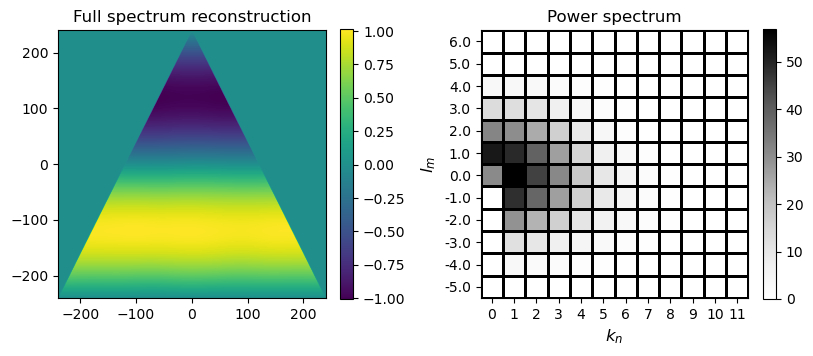

In [11]:
%matplotlib inline
fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
vmin = -1
vmax = 1

extent = [-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ]

im2 = axs[0].imshow(recons_z_2D, extent=extent, origin='lower', aspect='equal')
axs[0].set_title('Full spectrum reconstruction')
fig.colorbar(im2, ax=axs[0],fraction=0.2, pad=0.04, shrink=0.7)

im3 = axs[1].pcolormesh(np.abs(fourier_coeffs_full), edgecolors='k', cmap='Greys')
fig.colorbar(im3,ax=axs[1],fraction=0.2, pad=0.04, shrink=0.7)

m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)
    
ylocs = np.arange(.5,nhar_j+.5,1.0)

axs[1].set_yticks(ylocs, m_j)
axs[1].set_xticks(ylocs, np.arange(0,nhar_j))
axs[1].set_title("Power spectrum")
axs[1].set_xlabel(r'$k_n$', fontsize=12)
axs[1].set_ylabel(r'$l_m$', fontsize=12)
axs[1].set_aspect('equal')

plt.savefig('img/cos_tri.pdf')
plt.show()

In [17]:
zzt = np.ma.masked_array(z_masked, mask=~inout, fill_value=np.nan)

In [24]:
print(lat_rot.shape)
print(zzt.shape)

print(lat_rot)
print(lon_rot)

(480, 480)
(480, 480)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.0131173  0.0131173  0.0131173  ... 0.0131173  0.0131173  0.0131173 ]
 [0.02623459 0.02623459 0.02623459 ... 0.02623459 0.02623459 0.02623459]
 ...
 [6.25695071 6.25695071 6.25695071 ... 6.25695071 6.25695071 6.25695071]
 [6.27006801 6.27006801 6.27006801 ... 6.27006801 6.27006801 6.27006801]
 [6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]]
[[0.         0.0131173  0.02623459 ... 6.25695071 6.27006801 6.28318531]
 [0.         0.0131173  0.02623459 ... 6.25695071 6.27006801 6.28318531]
 [0.         0.0131173  0.02623459 ... 6.25695071 6.27006801 6.28318531]
 ...
 [0.         0.0131173  0.02623459 ... 6.25695071 6.27006801 6.28318531]
 [0.         0.0131173  0.02623459 ... 6.25695071 6.27006801 6.28318531]
 [0.         0.0131173  0.02623459 ... 6.25695071 6.27006801 6.28318531]]


In [22]:
from matplotlib import cm
%matplotlib qt
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
# Plot the surface.
surf = ax.plot_surface(lat_rot, lon_rot, zzt, vmax=1, vmin=-1, cmap=cm.viridis,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()